<a href="https://colab.research.google.com/github/hwanhuh/LG_AI_Lab/blob/main/Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 데이터 불러오기 및 이미지 전처리

In [1]:
import numpy as np
from PIL import Image
import json


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import torchvision.transforms as transforms

import torchvision.utils
import torchvision
from torchvision import models
import torchvision.datasets as dsets

import matplotlib.pyplot as plt

In [2]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

model = models.resnet34(pretrained=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!git clone https://github.com/hwanhuh/LG_AI_Lab.git

fatal: destination path 'LG_AI_Lab' already exists and is not an empty directory.


In [4]:
%cd LG_AI_Lab
!ls

/content/LG_AI_Lab
Image_Editing_with_StyleCLIP.ipynb  imagenet_class_index.json
imagenet			    README.md


In [5]:
!mkdir imagenet
!mv data ./imagenet 
!ls

mkdir: cannot create directory ‘imagenet’: File exists
mv: cannot stat 'data': No such file or directory
Image_Editing_with_StyleCLIP.ipynb  imagenet_class_index.json
imagenet			    README.md


In [6]:
# imagenet class 읽어오기 
idx = json.load(open(os.getcwd()+ '/imagenet_class_index.json'))
idx2class = [idx[str(i)][0] for i in range(len(idx))]

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

def image_preprocessing(root, transform, custom_label) :
    data = dsets.ImageFolder(root, transform)
    class2idx = {}
    
    for i, item in enumerate(idx2class):
        class2idx[item] = i
    
    new_data = dsets.ImageFolder(root, transform, 
                                 target_transform = lambda x : custom_label.index(data.classes[x]))
    new_data.classes = idx2class
    new_data.class2idx = class2idx

    return new_data

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
pre_data = image_preprocessing(root = os.getcwd() + '/imagenet/data', transform = transform, custom_label=idx2class)
pre_loader = Data.DataLoader(pre_data, batch_size=1, shuffle=False)

In [9]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (3, 9))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

(Before Attack) Predicted Label


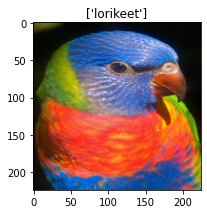

Confidence :76.45 %


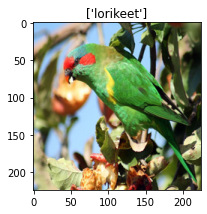

Confidence :40.22 %


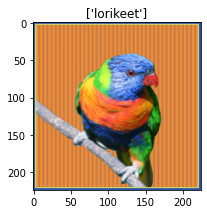

Confidence :32.48 %


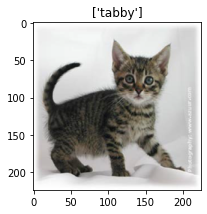

Confidence :46.40 %


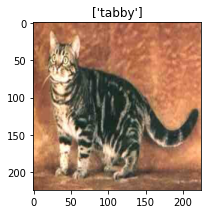

Confidence :36.55 %


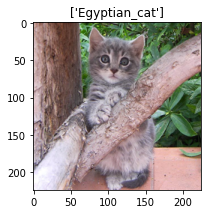

Confidence :28.61 %
Accuracy: 83.333333 %


In [10]:
# Dataset 의 사진들 출력해보기 

print("(Before Attack) Predicted Label")

model.to(device)
model.eval()

cnt = 0
total = 0

for images, labels in pre_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)

    cnt += (pre == labels).sum()
    total += 1

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [idx[str(int(i))][1] for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
        
print('Accuracy: %f %%' % (100 * float(cnt) / total))

## 2. Attack Method

### Fast Gradient Sign Method

In [11]:
def fgsm_attack(model,images,labels,eps) :
    
    images = images.to(device)
    images.requires_grad = True
    outputs = model(images)
    
    model.zero_grad()
    cost = nn.CrossEntropyLoss()(outputs, labels)
    cost = cost.to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1) 
    
    return attack_images

(FGSM Attack) Predicted Label


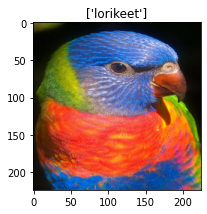

Confidence :62.02 %


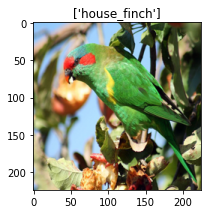

Confidence :36.72 %


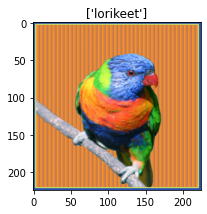

Confidence :21.50 %


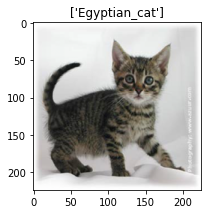

Confidence :45.47 %


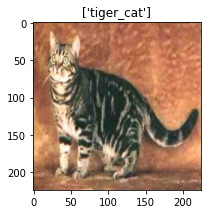

Confidence :37.17 %


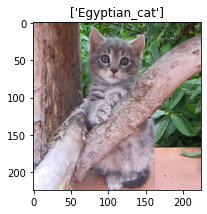

Confidence :25.04 %
Accuracy of test text: 33.333333 %


In [12]:
print("(FGSM Attack) Predicted Label")
model.eval()

cnt = 0
cnt2 = 0
total = 0

for images, labels in pre_loader:
    labels = labels.to(device)
    images = fgsm_attack(model, images, labels, 0.0002).to(device)
    
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)

    cnt += (pre == labels).sum()
    total += 1
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [idx[str(int(i))][1]  for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    
print('Accuracy of test text: %f %%' % (100 * float(cnt) / total))

### Projected Gradient Descent 

In [13]:
def pgd_attack(model, images, labels, eps, alpha, iters) :
    images = images.to(device)
    labels = labels.to(device)
        
    last_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = nn.CrossEntropyLoss()(outputs, labels)
        cost = cost.to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - last_images, min=-eps, max=eps)
        images = torch.clamp(last_images + eta, min=0, max=1).detach_()
            
    return images

(PGD Attack) Predicted Label


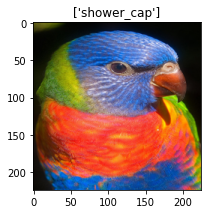

Confidence :12.59 %


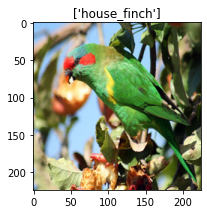

Confidence :94.95 %


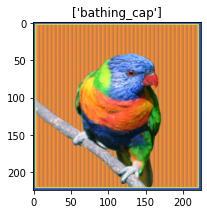

Confidence :53.09 %


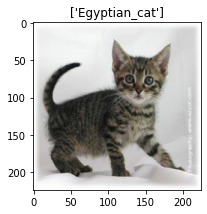

Confidence :94.37 %


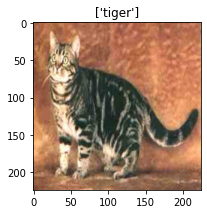

Confidence :44.44 %


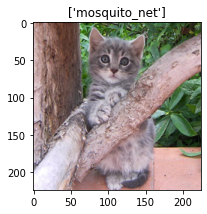

Confidence :49.76 %
Accuracy of test text: 0.000000 %


In [14]:
print("(PGD Attack) Predicted Label")
model.eval()

cnt = 0
cnt2 = 0
total = 0

for images, labels in pre_loader:
    labels = labels.to(device)
    images = pgd_attack(model, images, labels, 0.02, 0.0002, 10).to(device)
    
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)

    cnt += (pre == labels).sum()
    total += 1
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [idx[str(int(i))][1]  for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    
print('Accuracy of test text: %f %%' % (100 * float(cnt) / total))

### Least Likelyhood Attack 

In [15]:
def ll_class_attack(model, images, eps, alpha, iter) :
    images = images.to(device)    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
    last_images = images.data
        
    for i in range(iter) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = nn.CrossEntropyLoss()(outputs, labels)
        cost = cost.to(device)
        cost.backward()

        adv_images = images - eps*images.grad.sign()
        eta = torch.clamp(adv_images - last_images, min=-eps, max=eps)
        images = torch.clamp(last_images + eta, min=0, max=1).detach_()
    
    return images

(LL Attack) Predicted Label


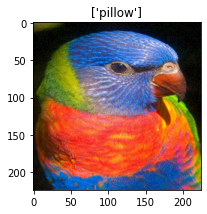

Confidence :16.32 %


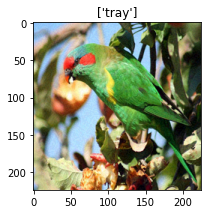

Confidence :11.80 %


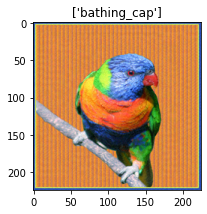

Confidence :21.68 %


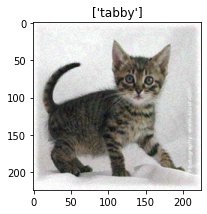

Confidence :13.59 %


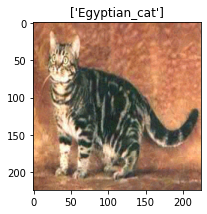

Confidence :21.44 %


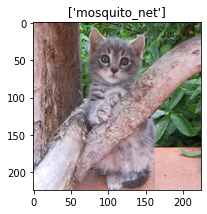

Confidence :13.05 %
Accuracy of test text: 16.666667 %


In [16]:
print("(LL Attack) Predicted Label")
model.eval()

cnt = 0
cnt2 = 0
total = 0

for images, labels in pre_loader:
    labels = labels.to(device)
    images = ll_class_attack(model, images, 0.02, 0.0002, 1).to(device)
    
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)

    cnt += (pre == labels).sum()
    total += 1
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [idx[str(int(i))][1]  for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    
print('Accuracy of test text: %f %%' % (100 * float(cnt) / total))